# Finance Python Tools by Paul Chao #

## Finance Crawler : 金融爬蟲 ##

## Is Yahoo finance API [broken](https://forums.yahoo.net/t5/Yahoo-Finance-help/Is-Yahoo-Finance-API-broken/td-p/250503/page/14)? ##
### Unfortunately, **YES**! ###

## Is Google finance API [broken](https://stackoverflow.com/questions/46090810/google-finance-api-not-working-from-6-september-2017)? ##
### Unfortunately, **YES**! ###

In [ ]:
!pip install requests, bs4

In [1]:
import requests

In [2]:
resp = requests.get("http://finance.google.com/finance?q=2330")

In [3]:
resp

<Response [200]>

In [18]:
print(resp.text)

<!DOCTYPE html><html><head><script>(function(){(function(){function e(a){this.t={};this.tick=function(a,c,b){var d=void 0!=b?b:(new Date).getTime();this.t[a]=[d,c];if(void 0==b)try{window.console.timeStamp("CSI/"+a)}catch(h){}};this.tick("start",null,a)}var a;if(window.performance)var d=(a=window.performance.timing)&&a.responseStart;var f=0<d?new e(d):new e;window.jstiming={Timer:e,load:f};if(a){var c=a.navigationStart;0<c&&d>=c&&(window.jstiming.srt=d-c)}if(a){var b=window.jstiming.load;0<c&&d>=c&&(b.tick("_wtsrt",void 0,c),b.tick("wtsrt_","_wtsrt",
d),b.tick("tbsd_","wtsrt_"))}try{a=null,window.chrome&&window.chrome.csi&&(a=Math.floor(window.chrome.csi().pageT),b&&0<c&&(b.tick("_tbnd",void 0,window.chrome.csi().startE),b.tick("tbnd_","_tbnd",c))),null==a&&window.gtbExternal&&(a=window.gtbExternal.pageT()),null==a&&window.external&&(a=window.external.pageT,b&&0<c&&(b.tick("_tbnd",void 0,window.external.startE),b.tick("tbnd_","_tbnd",c))),a&&(window.jstiming.pt=a)}catch(g){}})();}).cal

In [24]:
from bs4 import BeautifulSoup

resp = requests.get("http://finance.google.com/finance?q=2330")
soup = BeautifulSoup(resp.text, 'lxml')

price = soup.select('#ref_674465_l')
print(price)

[<span id="ref_674465_l">236.00</span>]


In [25]:
soup.select('#ref_674465_l')[0].text

'236.00'

In [26]:
price_change=soup.select('#ref_674465_c')[0].text
print(price_change)

+3.00


In [27]:
price_change=soup.select('#ref_674465_cp')[0].text
print(price_change)

(1.29%)


## 但事情不會盡如人意 ##

In [28]:
soup = soup.select('#price-panel')[0]
print(soup)

<div class="id-price-panel goog-inline-block" id="price-panel">
<div>
<span class="pr">
<span id="ref_674465_l">236.00</span>
</span>
<div class="id-price-change nwp">
<span class="ch bld"><span class="chg" id="ref_674465_c">+3.00</span>
<span class="chg" id="ref_674465_cp">(1.29%)</span>
</span>
</div>
</div>
<div>
<span class="nwp">
Real-time:
 
<span id="ref_674465_ltt">
12:27PM GMT+8
</span>
</span>
<div class="mdata-dis">
<span class="dis-large"><nobr>TPE
real-time data -
<a class="dis-large" href="//www.google.com/help/stock_disclaimer.html#realtime">Disclaimer</a>
</nobr></span>
<div>Currency in TWD</div>
</div>
</div>
</div>


In [29]:
soup.select('.pr')[0].text

'\n236.00\n'

In [36]:
if len(soup.select('.chg')) > 0:
    price_change = [soup.select('.chg')[0].text, soup.select('.chg')[1].text]
elif len(soup.select('.chb')) > 0:
    price_change = [soup.select('.chb')[0].text, soup.select('.chb')[1].text]

print(price_change)

['+3.00', '(1.29%)']


In [37]:
import requests
from bs4 import BeautifulSoup
resp = requests.get("http://finance.google.com/finance?q=2330")
soup = BeautifulSoup(resp.text, 'lxml')

#price=soup.select('#ref_674465_l')[0].text
#price_change = [soup.select('#ref_674465_c')[0].text, soup.select('#ref_674465_cp')[0].text]

soup = soup.select('#price-panel')[0]
price = float(soup.select('.pr')[0].text)

if len(soup.select('.chg')) > 0:
    price_change = [soup.select('.chg')[0].text, soup.select('.chg')[1].text]
elif len(soup.select('.chb')) > 0:
    price_change = [soup.select('.chb')[0].text, soup.select('.chb')[1].text]

print("Price, price_change = ", price, price_change)

Price, price_change =  236.5 ['+3.50', '(1.50%)']


## 取得目前股價 ##
包成一個函式，並且呼叫它。

In [38]:
import requests
from bs4 import BeautifulSoup

def get_price_from_google(quote):
    resp = requests.get("http://finance.google.com/finance?q={}".format(quote))
    if resp.status_code is 200:
        soup = BeautifulSoup(resp.text, 'lxml')

        soup = soup.select('#price-panel')[0]
        price = float(soup.select('.pr')[0].text)
        
        if len(soup.select('.chg')) > 0:
            price_change = [soup.select('.chg')[0].text, soup.select('.chg')[1].text]
        elif len(soup.select('.chb')) > 0:
            price_change = [soup.select('.chb')[0].text, soup.select('.chb')[1].text]

        print("Price, price_change = ", price, price_change)
    return price, price_change

quote_num = input("input quote number:")
print("Stock Price of {} = {}".format(quote_num, get_price_from_google(quote_num)))

input quote number:2330
Price, price_change =  236.5 ['+3.50', '(1.50%)']
Stock Price of 2330 = (236.5, ['+3.50', '(1.50%)'])


## 持續追蹤股價 - 鎖定個股追蹤器 ##
加一個迴圈持續來追蹤

file: google_test.py
``` Python
import requests
from bs4 import BeautifulSoup

def get_price_from_google(quote):
    resp = requests.get("http://finance.google.com/finance?q={}".format(quote))
    if resp.status_code is 200:
        soup = BeautifulSoup(resp.text, 'lxml')

        soup = soup.select('#price-panel')[0]
        price = float(soup.select('.pr')[0].text)        
        if len(soup.select('.chg')) > 0:
            price_change = [soup.select('.chg')[0].text, soup.select('.chg')[1].text]
        elif len(soup.select('.chb')) > 0:
            price_change = [soup.select('.chb')[0].text, soup.select('.chb')[1].text]
    return price, price_change

quote_num = input("input quote number:")
price_now = float(0)

while True:
    price_prev = price_now
    price_now, change = get_price_from_google(quote_num)

    if price_now > price_prev:
        print("Stock {} goes up - price({}), change({})".format(\
            quote_num, price_now, change))
    else:
        print("Stock {} goes down - price({}), change({})".format(\
            quote_num, price_now, change))
```

**結果:**

```
$ python google_test.py
input quote number:2330
Stock 2330 goes up - price(218.5), change(['+0.50', '(0.23%)'])
Stock 2330 goes down - price(218.5), change(['+0.50', '(0.23%)'])
Stock 2330 goes down - price(218.5), change(['+0.50', '(0.23%)'])
Stock 2330 goes down - price(218.5), change(['+0.50', '(0.23%)'])
Stock 2330 goes down - price(218.5), change(['+0.50', '(0.23%)'])
Stock 2330 goes down - price(218.5), change(['+0.50', '(0.23%)'])
Stock 2330 goes down - price(218.5), change(['+0.50', '(0.23%)'])
Stock 2330 goes down - price(218.5), change(['+0.50', '(0.23%)'])
Stock 2330 goes up - price(219.0), change(['+1.00', '(0.46%)'])
Stock 2330 goes down - price(219.0), change(['+1.00', '(0.46%)'])
Stock 2330 goes down - price(219.0), change(['+1.00', '(0.46%)'])
Stock 2330 goes down - price(219.0), change(['+1.00', '(0.46%)'])
Stock 2330 goes down - price(219.0), change(['+1.00', '(0.46%)'])
Stock 2330 goes down - price(219.0), change(['+1.00', '(0.46%)'])
Stock 2330 goes down - price(219.0), change(['+1.00', '(0.46%)'])
Stock 2330 goes down - price(219.0), change(['+1.00', '(0.46%)'])
Stock 2330 goes down - price(219.0), change(['+1.00', '(0.46%)'])
Stock 2330 goes down - price(219.0), change(['+1.00', '(0.46%)'])
Stock 2330 goes down - price(219.0), change(['+1.00', '(0.46%)'])
Stock 2330 goes down - price(219.0), change(['+1.00', '(0.46%)'])
Stock 2330 goes down - price(218.5), change(['+0.50', '(0.23%)'])
Stock 2330 goes down - price(218.5), change(['+0.50', '(0.23%)'])
Stock 2330 goes down - price(218.5), change(['+0.50', '(0.23%)'])
Stock 2330 goes down - price(218.5), change(['+0.50', '(0.23%)'])
Stock 2330 goes down - price(218.5), change(['+0.50', '(0.23%)'])
Stock 2330 goes down - price(218.5), change(['+0.50', '(0.23%)'])
Stock 2330 goes down - price(218.5), change(['+0.50', '(0.23%)'])
Stock 2330 goes down - price(218.5), change(['+0.50', '(0.23%)'])
Stock 2330 goes down - price(218.5), change(['+0.50', '(0.23%)'])
Stock 2330 goes down - price(218.5), change(['+0.50', '(0.23%)'])
Stock 2330 goes down - price(218.5), change(['+0.50', '(0.23%)'])
Stock 2330 goes down - price(218.5), change(['+0.50', '(0.23%)'])
Stock 2330 goes down - price(218.5), change(['+0.50', '(0.23%)'])
Stock 2330 goes down - price(218.5), change(['+0.50', '(0.23%)'])
Stock 2330 goes down - price(218.5), change(['+0.50', '(0.23%)'])
Stock 2330 goes down - price(218.5), change(['+0.50', '(0.23%)'])
Stock 2330 goes down - price(218.5), change(['+0.50', '(0.23%)'])
Stock 2330 goes down - price(218.5), change(['+0.50', '(0.23%)'])
Stock 2330 goes down - price(218.5), change(['+0.50', '(0.23%)'])
Stock 2330 goes down - price(218.5), change(['+0.50', '(0.23%)'])
Stock 2330 goes down - price(218.5), change(['+0.50', '(0.23%)'])
Stock 2330 goes down - price(218.5), change(['+0.50', '(0.23%)'])
Stock 2330 goes down - price(218.5), change(['+0.50', '(0.23%)'])
Stock 2330 goes down - price(218.5), change(['+0.50', '(0.23%)'])
Stock 2330 goes down - price(218.5), change(['+0.50', '(0.23%)'])
Stock 2330 goes down - price(218.5), change(['+0.50', '(0.23%)'])
Stock 2330 goes down - price(218.5), change(['+0.50', '(0.23%)'])
Stock 2330 goes down - price(218.5), change(['+0.50', '(0.23%)'])
Stock 2330 goes down - price(218.5), change(['+0.50', '(0.23%)'])
Stock 2330 goes down - price(218.5), change(['+0.50', '(0.23%)'])
Stock 2330 goes down - price(218.5), change(['+0.50', '(0.23%)'])
Stock 2330 goes down - price(218.5), change(['+0.50', '(0.23%)'])
Stock 2330 goes down - price(218.5), change(['+0.50', '(0.23%)'])
Stock 2330 goes up - price(219.0), change(['+1.00', '(0.46%)'])
Stock 2330 goes down - price(219.0), change(['+1.00', '(0.46%)'])
Stock 2330 goes down - price(219.0), change(['+1.00', '(0.46%)'])
Stock 2330 goes down - price(219.0), change(['+1.00', '(0.46%)'])
Stock 2330 goes down - price(219.0), change(['+1.00', '(0.46%)'])
Stock 2330 goes down - price(219.0), change(['+1.00', '(0.46%)'])
Stock 2330 goes down - price(219.0), change(['+1.00', '(0.46%)'])
Stock 2330 goes down - price(219.0), change(['+1.00', '(0.46%)'])
Stock 2330 goes down - price(219.0), change(['+1.00', '(0.46%)'])
Stock 2330 goes down - price(219.0), change(['+1.00', '(0.46%)'])
Stock 2330 goes down - price(219.0), change(['+1.00', '(0.46%)'])
Stock 2330 goes down - price(219.0), change(['+1.00', '(0.46%)'])
Stock 2330 goes down - price(219.0), change(['+1.00', '(0.46%)'])
Stock 2330 goes down - price(219.0), change(['+1.00', '(0.46%)'])
Stock 2330 goes down - price(219.0), change(['+1.00', '(0.46%)'])
Stock 2330 goes down - price(219.0), change(['+1.00', '(0.46%)'])
Stock 2330 goes down - price(219.0), change(['+1.00', '(0.46%)'])
Stock 2330 goes down - price(219.0), change(['+1.00', '(0.46%)'])
Stock 2330 goes down - price(219.0), change(['+1.00', '(0.46%)'])
Stock 2330 goes down - price(219.0), change(['+1.00', '(0.46%)'])
Stock 2330 goes down - price(219.0), change(['+1.00', '(0.46%)'])
Stock 2330 goes down - price(219.0), change(['+1.00', '(0.46%)'])
Stock 2330 goes down - price(219.0), change(['+1.00', '(0.46%)'])
Stock 2330 goes down - price(219.0), change(['+1.00', '(0.46%)'])
Stock 2330 goes down - price(219.0), change(['+1.00', '(0.46%)'])
Stock 2330 goes down - price(219.0), change(['+1.00', '(0.46%)'])
Stock 2330 goes down - price(219.0), change(['+1.00', '(0.46%)'])
Stock 2330 goes down - price(219.0), change(['+1.00', '(0.46%)'])
Stock 2330 goes down - price(219.0), change(['+1.00', '(0.46%)'])
Stock 2330 goes down - price(219.0), change(['+1.00', '(0.46%)'])
Stock 2330 goes down - price(219.0), change(['+1.00', '(0.46%)'])
Stock 2330 goes down - price(219.0), change(['+1.00', '(0.46%)'])
Stock 2330 goes down - price(219.0), change(['+1.00', '(0.46%)'])
Stock 2330 goes down - price(219.0), change(['+1.00', '(0.46%)'])
Stock 2330 goes down - price(219.0), change(['+1.00', '(0.46%)'])
Stock 2330 goes down - price(219.0), change(['+1.00', '(0.46%)'])
Stock 2330 goes down - price(219.0), change(['+1.00', '(0.46%)'])
Stock 2330 goes down - price(219.0), change(['+1.00', '(0.46%)'])
Stock 2330 goes down - price(219.0), change(['+1.00', '(0.46%)'])
Stock 2330 goes down - price(219.0), change(['+1.00', '(0.46%)'])
Stock 2330 goes down - price(219.0), change(['+1.00', '(0.46%)'])
Stock 2330 goes down - price(219.0), change(['+1.00', '(0.46%)'])
Stock 2330 goes down - price(219.0), change(['+1.00', '(0.46%)'])
Stock 2330 goes down - price(219.0), change(['+1.00', '(0.46%)'])
Stock 2330 goes down - price(219.0), change(['+1.00', '(0.46%)'])
Stock 2330 goes down - price(219.0), change(['+1.00', '(0.46%)'])
Stock 2330 goes down - price(219.0), change(['+1.00', '(0.46%)'])
Stock 2330 goes down - price(219.0), change(['+1.00', '(0.46%)'])
Stock 2330 goes down - price(219.0), change(['+1.00', '(0.46%)'])
Stock 2330 goes down - price(219.0), change(['+1.00', '(0.46%)'])
Stock 2330 goes down - price(219.0), change(['+1.00', '(0.46%)'])
Stock 2330 goes down - price(218.5), change(['+0.50', '(0.23%)'])
Stock 2330 goes down - price(218.5), change(['+0.50', '(0.23%)'])
Stock 2330 goes down - price(218.5), change(['+0.50', '(0.23%)'])
Stock 2330 goes down - price(218.5), change(['+0.50', '(0.23%)'])
Stock 2330 goes down - price(218.5), change(['+0.50', '(0.23%)'])
```


## 變動時再刷牆 - 價格跳動看板 ##
用if來作一點條件判斷

``` Python
import requests
from bs4 import BeautifulSoup

def get_price_from_google(quote):
    resp = requests.get("http://finance.google.com/finance?q={}".format(quote))
    if resp.status_code is 200:
        soup = BeautifulSoup(resp.text, 'lxml')

        soup = soup.select('#price-panel')[0]
        price = float(soup.select('.pr')[0].text)
        
        if len(soup.select('.chg')) > 0:
            price_change = [soup.select('.chg')[0].text, soup.select('.chg')[1].text]
        elif len(soup.select('.chb')) > 0:
            price_change = [soup.select('.chb')[0].text, soup.select('.chb')[1].text]

    return float(price), price_change

quote_num = input("input quote number:")
price_now = float(0)

while True:
    price_prev = price_now  #承接前值
    price_now, change = get_price_from_google(quote_num)
    if price_now !=  price_prev: #變動才進行
        if price_now > price_prev:
            print("Stock {} goes up - price({}), change({})".format(\
                quote_num, price_now, change))
        else:
            print("Stock {} goes down - price({}), change({})".format(\
                quote_num, price_now, change))
```

**結果:**
``` Python
$ python google_test.py
input quote number:2330
Stock 2330 goes up - price(219.0), change(['+1.00', '(0.46%)'])
Stock 2330 goes down - price(218.5), change(['+0.50', '(0.23%)'])
Stock 2330 goes up - price(219.0), change(['+1.00', '(0.46%)'])
Stock 2330 goes down - price(218.5), change(['+0.50', '(0.23%)'])
Stock 2330 goes up - price(219.0), change(['+1.00', '(0.46%)'])
Stock 2330 goes down - price(218.5), change(['+0.50', '(0.23%)'])
Stock 2330 goes up - price(219.0), change(['+1.00', '(0.46%)'])
```

## 打上時間戳記 ##

In [7]:
import time
print(time.ctime())

Thu Sep 14 17:03:07 2017


``` Python
import requests, time
from bs4 import BeautifulSoup

def get_price_from_google(quote):
    resp = requests.get("http://finance.google.com/finance?q={}".format(quote))
    if resp.status_code is 200:
        soup = BeautifulSoup(resp.text, 'lxml')

        soup = soup.select('#price-panel')[0]
        price = float(soup.select('.pr')[0].text)        
        if len(soup.select('.chg')) > 0:
            price_change = [soup.select('.chg')[0].text, soup.select('.chg')[1].text]
        elif len(soup.select('.chb')) > 0:
            price_change = [soup.select('.chb')[0].text, soup.select('.chb')[1].text]
    return price, price_change

quote_num = input("input quote number:")
price_now = float(0)

while True:
    price_prev = price_now
    price_now, change = get_price_from_google(quote_num)
    if price_now !=  price_prev:
        if price_now > price_prev:
            print("{}: Stock {} goes up - price({}), change({})".format(\
                time.ctime(), quote_num, price_now, change))
        else:
            print("{}: Stock {} goes down - price({}), change({})".format(\
                time.ctime(), quote_num, price_now, change))

```
**結果**

``` bash 
$ python google_test.py
Fri Sep 22 07:34:09 2017: Stock 2332 goes up - price(11.1), change(['-0.20', '(-1.77%)'])
```

## 最簡單的策略判斷 ##
建立判斷的函數。

策略判斷深似海 ...
先從最簡單開始 ...
#### 定價買、定價賣 ####
``` Python
def fixed_buy_strategy(now_price, fixed_buy_price):
    if float(now_price) <  float(fixed_buy_price):
        return True  # buy it!
    else:
        return False # no action

def fixed_sell_strategy(now_price, fixed_sell_price):
    if float(now_price) >= float(fixed_sell_price):
        return True  # sell it!
    else:
        return False # no action
```

**結合到原有程式裡**
``` Python
import requests, re, time
from bs4 import BeautifulSoup

def get_price_from_google(quote):
    resp = requests.get("http://finance.google.com/finance?q={}".format(quote))
    if resp.status_code is 200:
        soup = BeautifulSoup(resp.text, 'lxml')

        soup = soup.select('#price-panel')[0]
        price = float(soup.select('.pr')[0].text)        
        if len(soup.select('.chg')) > 0:
            price_change = [soup.select('.chg')[0].text, soup.select('.chg')[1].text]
        elif len(soup.select('.chb')) > 0:
            price_change = [soup.select('.chb')[0].text, soup.select('.chb')[1].text]
    return price, price_change

def fixed_buy_strategy(now_price, fixed_buy_price):
    if float(now_price) <  float(fixed_buy_price):
        return True  # buy it!
    else:
        return False # no action

def fixed_sell_strategy(now_price, fixed_sell_price):
    if float(now_price) >= float(fixed_sell_price):
        return True  # sell it!
    else:
        return False # no action

quote_num = input("input quote number:")
buy_price = input("Set fixed buy price:")
sell_price = input("Set fixed sell price:")
price_now = float(0)

while True:
    price_prev = price_now
    price_now, change = get_price_from_google(quote_num)
    if fixed_buy_strategy(price_now, buy_price):
        print("{}: Buy stock {} at price({}), fixed buy price({}))".format(\
            time.ctime(), quote_num, price_now, buy_price))
    elif fixed_sell_strategy(price_now, sell_price):
        print("{}: Sell stock {} at price({}), fixed sell price({})".format(\
            time.ctime(), quote_num, price_now, sell_price))
```

``` bash
$ python3 google_test.py
input quote number:LON:LSE
Set fixed buy price:3775
Set fixed sell price:3770
Fri Sep 22 08:09:33 2017: Buy stock LON:LSE at price(3774.0), fixed buy price(3775))
Fri Sep 22 08:09:33 2017: Buy stock LON:LSE at price(3774.0), fixed buy price(3775))
Fri Sep 22 08:09:33 2017: Buy stock LON:LSE at price(3774.0), fixed buy price(3775))
Fri Sep 22 08:09:34 2017: Buy stock LON:LSE at price(3774.0), fixed buy price(3775))
Fri Sep 22 08:09:34 2017: Buy stock LON:LSE at price(3774.0), fixed buy price(3775))
Fri Sep 22 08:09:34 2017: Buy stock LON:LSE at price(3774.0), fixed buy price(3775))
Fri Sep 22 08:09:35 2017: Buy stock LON:LSE at price(3774.0), fixed buy price(3775))
Fri Sep 22 08:09:35 2017: Buy stock LON:LSE at price(3774.0), fixed buy price(3775))
Fri Sep 22 08:09:35 2017: Buy stock LON:LSE at price(3774.0), fixed buy price(3775))
Fri Sep 22 08:09:35 2017: Buy stock LON:LSE at price(3774.0), fixed buy price(3775))
Fri Sep 22 08:09:36 2017: Buy stock LON:LSE at price(3774.0), fixed buy price(3775))
Fri Sep 22 08:09:36 2017: Buy stock LON:LSE at price(3774.0), fixed buy price(3775))
Fri Sep 22 08:09:37 2017: Buy stock LON:LSE at price(3774.0), fixed buy price(3775))
Fri Sep 22 08:09:37 2017: Buy stock LON:LSE at price(3774.0), fixed buy price(3775))
Fri Sep 22 08:09:38 2017: Buy stock LON:LSE at price(3774.0), fixed buy price(3775))
Fri Sep 22 08:09:38 2017: Buy stock LON:LSE at price(3774.0), fixed buy price(3775))
Fri Sep 22 08:09:38 2017: Buy stock LON:LSE at price(3774.0), fixed buy price(3775))
Fri Sep 22 08:09:39 2017: Buy stock LON:LSE at price(3774.0), fixed buy price(3775))
```

### 子彈有限、買過不要再買、賣過不要再賣 ###
設立開關
``` Python
quote_num = input("input quote number:")
buy_price = input("Set fixed buy price:")
sell_price = input("Set fixed sell price:")
price_now = float(0)
already_bought = False
already_sold = False


while True:
    price_prev = price_now
    price_now, change = get_price_from_google(quote_num)
    if fixed_buy_strategy(price_now, buy_price) and already_bought==False:
        print("{}: Buy stock {} at price({}), fixed buy price({}))".format(\
            time.ctime(), quote_num, price_now, buy_price))
        already_bought = True  # done, no more
    elif fixed_sell_strategy(price_now, sell_price) and already_sold==False:
        print("{}: Sell stock {} at price({}), fixed sell price({})".format(\
            time.ctime(), quote_num, price_now, sell_price))
        already_sold = True  # done, no more
```

**放進原有的程式裡**
``` Python
import requests, time
from bs4 import BeautifulSoup

def get_price_from_google(quote):
    resp = requests.get("http://finance.google.com/finance?q={}".format(quote))
    if resp.status_code is 200:
        soup = BeautifulSoup(resp.text, 'lxml')

        soup = soup.select('#price-panel')[0]
        price = float(soup.select('.pr')[0].text)        
        if len(soup.select('.chg')) > 0:
            price_change = [soup.select('.chg')[0].text, soup.select('.chg')[1].text]
        elif len(soup.select('.chb')) > 0:
            price_change = [soup.select('.chb')[0].text, soup.select('.chb')[1].text]
    return price, price_change

def fixed_buy_strategy(now_price, fixed_buy_price):
    if float(now_price) <  float(fixed_buy_price):
        return True  # buy it!
    else:
        return False # no action

def fixed_sell_strategy(now_price, fixed_sell_price):
    if float(now_price) >= float(fixed_sell_price):
        return True  # sell it!
    else:
        return False # no action

quote_num = input("input quote number:")
buy_price = input("Set fixed buy price:")
sell_price = input("Set fixed sell price:")
price_now = float(0)
already_bought = False
already_sold = False


while True:
    price_prev = price_now
    price_now, change = get_price_from_google(quote_num)
    if fixed_buy_strategy(price_now, buy_price) and already_bought==False:
        print("{}: Buy stock {} at price({}), fixed buy price({}))".format(\
            time.ctime(), quote_num, price_now, buy_price))
        already_bought = True  # done
    elif fixed_sell_strategy(price_now, sell_price) and already_sold==False:
        print("{}: Sell stock {} at price({}), fixed sell price({})".format(\
            time.ctime(), quote_num, price_now, sell_price))
        already_sold = True
```
結果:
``` bash
$ python3 google_test.py
input quote number:LON:LSE
Set fixed buy price:3770
Set fixed sell price:3775
Fri Sep 22 08:22:40 2017: Buy stock LON:LSE at price(3769.0), fixed buy price(3770))
```

### 控制張數 ###
設立臨界點

``` Python
quote_num = input("input quote number:")
buy_price = input("Set fixed buy price:")
sell_price = input("Set fixed sell price:")
price_now = float(0)
quote_in_hand = 0


while True:
    price_prev = price_now
    price_now, change = get_price_from_google(quote_num)
    if fixed_buy_strategy(price_now, buy_price) and quote_in_hand<6:
        print("{}: Buy stock {} at price({}), fixed buy price({}))".format(\
            time.ctime(), quote_num, price_now, buy_price))
        quote_in_hand += 1
    elif fixed_sell_strategy(price_now, sell_price) and quote_in_hand>0:
        print("{}: Sell stock {} at price({}), fixed sell price({})".format(\
            time.ctime(), quote_num, price_now, sell_price))
        quote_in_hand -=1
```

``` bash
$ python3 google_test.py
input quote number:LON:LSE
Set fixed buy price:3773
Set fixed sell price:3775
Fri Sep 22 08:36:24 2017: Buy stock LON:LSE at price(3772.0), fixed buy price(3773))
Fri Sep 22 08:36:24 2017: Buy stock LON:LSE at price(3772.0), fixed buy price(3773))
Fri Sep 22 08:36:24 2017: Buy stock LON:LSE at price(3772.0), fixed buy price(3773))
Fri Sep 22 08:36:25 2017: Buy stock LON:LSE at price(3772.0), fixed buy price(3773))
Fri Sep 22 08:36:25 2017: Buy stock LON:LSE at price(3772.0), fixed buy price(3773))
Fri Sep 22 08:36:25 2017: Buy stock LON:LSE at price(3772.0), fixed buy price(3773))
```

## 歷史股價 ##
- [google finance](https://finance.google.com/finance/historical?q=2330), 以2330為例。

In [2]:
import requests
resp = requests.get("https://finance.google.com/finance/historical?q=2330")
print(resp.text)

<!DOCTYPE html><html><head><script>(function(){(function(){function e(a){this.t={};this.tick=function(a,c,b){var d=void 0!=b?b:(new Date).getTime();this.t[a]=[d,c];if(void 0==b)try{window.console.timeStamp("CSI/"+a)}catch(h){}};this.tick("start",null,a)}var a;if(window.performance)var d=(a=window.performance.timing)&&a.responseStart;var f=0<d?new e(d):new e;window.jstiming={Timer:e,load:f};if(a){var c=a.navigationStart;0<c&&d>=c&&(window.jstiming.srt=d-c)}if(a){var b=window.jstiming.load;0<c&&d>=c&&(b.tick("_wtsrt",void 0,c),b.tick("wtsrt_","_wtsrt",
d),b.tick("tbsd_","wtsrt_"))}try{a=null,window.chrome&&window.chrome.csi&&(a=Math.floor(window.chrome.csi().pageT),b&&0<c&&(b.tick("_tbnd",void 0,window.chrome.csi().startE),b.tick("tbnd_","_tbnd",c))),null==a&&window.gtbExternal&&(a=window.gtbExternal.pageT()),null==a&&window.external&&(a=window.external.pageT,b&&0<c&&(b.tick("_tbnd",void 0,window.external.startE),b.tick("tbnd_","_tbnd",c))),a&&(window.jstiming.pt=a)}catch(g){}})();}).cal

In [5]:
from bs4 import BeautifulSoup
soup = BeautifulSoup(resp.text, 'lxml')

hist_table = soup.find("table", { "class": "gf-table historical_price" })

print(hist_table)

<table class="gf-table historical_price">
<tr class="bb">
<th class="bb lm lft">Date
</th><th class="rgt bb">Open
</th><th class="rgt bb">High
</th><th class="rgt bb">Low
</th><th class="rgt bb">Close
</th><th class="rgt bb rm">Volume
</th></tr><tr>
<td class="lm">Sep 21, 2017
</td><td class="rgt">221.00
</td><td class="rgt">223.00
</td><td class="rgt">220.00
</td><td class="rgt">221.00
</td><td class="rgt rm">18,609,000
</td></tr><tr>
<td class="lm">Sep 20, 2017
</td><td class="rgt">221.00
</td><td class="rgt">222.00
</td><td class="rgt">220.00
</td><td class="rgt">221.50
</td><td class="rgt rm">20,278,000
</td></tr><tr>
<td class="lm">Sep 19, 2017
</td><td class="rgt">221.50
</td><td class="rgt">221.50
</td><td class="rgt">220.00
</td><td class="rgt">221.50
</td><td class="rgt rm">23,366,000
</td></tr><tr>
<td class="lm">Sep 18, 2017
</td><td class="rgt">219.00
</td><td class="rgt">220.00
</td><td class="rgt">218.00
</td><td class="rgt">219.50
</td><td class="rgt rm">17,614,000
</td>

In [11]:
import pandas as pd
raw_table = pd.read_html(resp.text)
raw_table

[    0   1    2
 0 NaN NaN  222
 1 NaN NaN  207
 2 NaN NaN  192,               0   1             2
 0  Sep 23, 2016 NaN  Sep 21, 2017,                0       1       2       3       4         5
 0           Date    Open    High     Low   Close    Volume
 1   Sep 21, 2017  221.00  223.00  220.00  221.00  18609000
 2   Sep 20, 2017  221.00  222.00  220.00  221.50  20278000
 3   Sep 19, 2017  221.50  221.50  220.00  221.50  23366000
 4   Sep 18, 2017  219.00  220.00  218.00  219.50  17614000
 5   Sep 15, 2017  218.50  219.00  217.00  218.50  44520000
 6   Sep 14, 2017  218.50  219.00  217.50  218.50  18297000
 7   Sep 13, 2017  217.50  219.00  217.50  218.00  17528000
 8   Sep 12, 2017  219.00  219.50  217.50  219.00  21540000
 9   Sep 11, 2017  219.00  219.50  216.50  217.00  18987000
 10   Sep 8, 2017  217.00  218.00  216.50  218.00  25473000
 11   Sep 7, 2017  218.00  218.50  216.00  217.00  19112000
 12   Sep 6, 2017  216.50  218.00  216.00  217.00  15986000
 13   Sep 5, 2017  218.00 

In [12]:
type(raw_table)

list

In [15]:
hist_table = raw_table[2]
hist_table

,0,1,2,3,4,5
0,Date,Open,High,Low,Close,Volume
1,"Sep 21, 2017",221.00,223.00,220.00,221.00,18609000
2,"Sep 20, 2017",221.00,222.00,220.00,221.50,20278000
3,"Sep 19, 2017",221.50,221.50,220.00,221.50,23366000
4,"Sep 18, 2017",219.00,220.00,218.00,219.50,17614000
5,"Sep 15, 2017",218.50,219.00,217.00,218.50,44520000
6,"Sep 14, 2017",218.50,219.00,217.50,218.50,18297000
7,"Sep 13, 2017",217.50,219.00,217.50,218.00,17528000
8,"Sep 12, 2017",219.00,219.50,217.50,219.00,21540000
9,"Sep 11, 2017",219.00,219.50,216.50,217.00,18987000


In [16]:
type(hist_table)

pandas.core.frame.DataFrame

In [19]:
hist_table.columns

Int64Index([0, 1, 2, 3, 4, 5], dtype='int64')

In [20]:
hist_table.columns = ['Date','Open','High','Low','Close','Volume']

In [21]:
hist_table

,Date,Open,High,Low,Close,Volume
0,Date,Open,High,Low,Close,Volume
1,"Sep 21, 2017",221.00,223.00,220.00,221.00,18609000
2,"Sep 20, 2017",221.00,222.00,220.00,221.50,20278000
3,"Sep 19, 2017",221.50,221.50,220.00,221.50,23366000
4,"Sep 18, 2017",219.00,220.00,218.00,219.50,17614000
5,"Sep 15, 2017",218.50,219.00,217.00,218.50,44520000
6,"Sep 14, 2017",218.50,219.00,217.50,218.50,18297000
7,"Sep 13, 2017",217.50,219.00,217.50,218.00,17528000
8,"Sep 12, 2017",219.00,219.50,217.50,219.00,21540000
9,"Sep 11, 2017",219.00,219.50,216.50,217.00,18987000


In [27]:
hist_table = hist_table.drop(hist_table.index[[0]])
hist_table

,Date,Open,High,Low,Close,Volume
1,"Sep 21, 2017",221.00,223.00,220.00,221.00,18609000
2,"Sep 20, 2017",221.00,222.00,220.00,221.50,20278000
3,"Sep 19, 2017",221.50,221.50,220.00,221.50,23366000
4,"Sep 18, 2017",219.00,220.00,218.00,219.50,17614000
5,"Sep 15, 2017",218.50,219.00,217.00,218.50,44520000
6,"Sep 14, 2017",218.50,219.00,217.50,218.50,18297000
7,"Sep 13, 2017",217.50,219.00,217.50,218.00,17528000
8,"Sep 12, 2017",219.00,219.50,217.50,219.00,21540000
9,"Sep 11, 2017",219.00,219.50,216.50,217.00,18987000
10,"Sep 8, 2017",217.00,218.00,216.50,218.00,25473000


**把程式整合起來**
google_hist.py
``` Python
import requests
import pandas as pd

quote_num = input("Quote number for history query:")

resp = requests.get("https://finance.google.com/finance/historical?q={}".format(quote_num))

raw_table = pd.read_html(resp.text)
hist_table = raw_table[2]
hist_table.columns = ['Date','Open','High','Low','Close','Volume']
hist_table = hist_table.drop(hist_table.index[[0]])
print(hist_table)
```
安裝套件
``` bash
$ pip install pandas
Collecting pandas
  Downloading pandas-0.20.3-cp35-cp35m-manylinux1_x86_64.whl (24.0MB)
    100% |████████████████████████████████| 24.0MB 60kB/s
Collecting numpy>=1.7.0 (from pandas)
  Downloading numpy-1.13.1-cp35-cp35m-manylinux1_x86_64.whl (16.9MB)
    100% |████████████████████████████████| 16.9MB 89kB/s
Collecting pytz>=2011k (from pandas)
  Using cached pytz-2017.2-py2.py3-none-any.whl
Collecting python-dateutil>=2 (from pandas)
  Using cached python_dateutil-2.6.1-py2.py3-none-any.whl
Collecting six>=1.5 (from python-dateutil>=2->pandas)
  Downloading six-1.11.0-py2.py3-none-any.whl
Installing collected packages: numpy, pytz, six, python-dateutil, pandas
Successfully installed numpy-1.13.1 pandas-0.20.3 python-dateutil-2.6.1 pytz-2017.2 six-1.11.0

$ pip install html5lib
Collecting html5lib
  Downloading html5lib-0.999999999-py2.py3-none-any.whl (112kB)
    100% |████████████████████████████████| 122kB 5.0MB/s
Requirement already satisfied: setuptools>=18.5 in ./env/lib/python3.5/site-packages (from html5lib)
Collecting webencodings (from html5lib)
  Downloading webencodings-0.5.1-py2.py3-none-any.whl
Requirement already satisfied: six in ./env/lib/python3.5/site-packages (from html5lib)
Installing collected packages: webencodings, html5lib
Successfully installed html5lib-0.999999999 webencodings-0.5.1
```
執行

``` bash
$ python3 google_hist.py
Quote number for history query:2330
            Date    Open    High     Low   Close   Volume
1   Sep 21, 2017  330.00  341.00  328.00  331.00   553000
2   Sep 20, 2017  338.00  339.00  327.00  330.00   659200
3   Sep 19, 2017  344.00  348.00  338.00  341.00   534100
4   Sep 15, 2017  332.00  343.00  325.00  340.00   685100
5   Sep 14, 2017  345.00  347.00  332.00  336.00   763400
6   Sep 13, 2017  352.00  362.00  346.00  348.00  1115600
7   Sep 12, 2017  338.00  352.00  337.00  352.00  1131900
8   Sep 11, 2017  330.00  353.00  326.00  338.00  1562200
9    Sep 8, 2017  326.00  335.00  319.00  323.00  1010200
10   Sep 7, 2017  330.00  338.00  320.00  322.00  1197200
11   Sep 6, 2017  300.00  326.00  295.00  316.00   974400
12   Sep 5, 2017  329.00  333.00  307.00  312.00  1352100
13   Sep 4, 2017  357.00  357.00  327.00  329.00  1330900
14   Sep 1, 2017  367.00  371.00  350.00  353.00   969600
15  Aug 31, 2017  362.00  372.00  356.00  371.00   915500
16  Aug 30, 2017  391.00  392.00  361.00  362.00  1580900
17  Aug 29, 2017  385.00  390.00  376.00  385.00  1796900
18  Aug 28, 2017  373.00  397.00  368.00  395.00  2879700
19  Aug 25, 2017  362.00  381.00  356.00  361.00  2863600
20  Aug 24, 2017  338.00  354.00  334.00  350.00   897000
21  Aug 23, 2017  338.00  349.00  333.00  340.00   928000
22  Aug 22, 2017  342.00  347.00  328.00  330.00   695700
23  Aug 21, 2017  322.00  344.00  317.00  338.00   987000
24  Aug 18, 2017  317.00  328.00  314.00  320.00   570400
25  Aug 17, 2017  321.00  331.00  321.00  324.00   808800
26  Aug 16, 2017  349.00  355.00  318.00  320.00  4319900
27  Aug 15, 2017  302.00  318.00  302.00  314.00   770800
28  Aug 14, 2017  296.00  318.00  288.00  314.00   943500
29  Aug 10, 2017  318.00  321.00  302.00  304.00   734700
30   Aug 9, 2017  318.00  323.00  306.00  314.00  1026300
```


#### 換另一家試試看 ####
2332 會衝到， TPE:2332

``` bash
$ python3 google_hist.py
Quote number for history query:TPE:2332
            Date   Open   High    Low  Close    Volume
1   Sep 21, 2017  11.25  11.35  11.20  11.30   1516000
2   Sep 20, 2017  11.45  11.50  11.10  11.25   2677000
3   Sep 19, 2017  11.60  11.65  11.40  11.45   1844000
4   Sep 18, 2017  11.65  11.85  11.45  11.50   2451000
5   Sep 15, 2017  11.40  11.80  11.35  11.65   9328000
6   Sep 14, 2017  11.45  11.50  11.35  11.35   1686000
7   Sep 13, 2017  11.60  11.65  11.40  11.40   2731000
8   Sep 12, 2017  11.40  12.00  11.40  11.60   8958000
9   Sep 11, 2017  11.25  11.55  11.20  11.35   3675000
10   Sep 8, 2017  11.30  11.40  11.20  11.20   3235000
11   Sep 7, 2017  11.45  11.55  11.30  11.30   3436000
12   Sep 6, 2017  11.50  11.65  11.30  11.40   8702000
13   Sep 5, 2017  10.75  11.75  10.75  11.75  16113000
14   Sep 4, 2017  10.85  10.90  10.70  10.70   1056000
15   Sep 1, 2017  11.00  11.00  10.80  10.90   1650000
16  Aug 31, 2017  10.75  11.10  10.75  10.90   4863000
17  Aug 30, 2017  10.70  10.75  10.65  10.75   1271000
18  Aug 29, 2017  10.75  10.95  10.55  10.60   2892000
19  Aug 28, 2017  10.75  10.85  10.60  10.75   1432000
20  Aug 25, 2017  10.75  10.85  10.65  10.75   2094000
21  Aug 24, 2017  10.50  10.70  10.50  10.70   2263000
22  Aug 23, 2017  10.50  10.65  10.40  10.40   1973000
23  Aug 22, 2017  10.40  10.45  10.35  10.40    776000
24  Aug 21, 2017  10.40  10.45  10.30  10.35    600000
25  Aug 18, 2017  10.35  10.45  10.30  10.40    789000
26  Aug 17, 2017  10.15  10.50  10.10  10.50   6811000
27  Aug 16, 2017   9.94  10.10   9.90  10.05   2106000
28  Aug 15, 2017   9.90  10.05   9.90   9.98   1152000
29  Aug 14, 2017  10.25  10.30   9.85   9.85   2491000
30  Aug 11, 2017  10.00  10.35  10.00  10.20   1925000
```

#### 換google試試 ####
GOOG
``` bash
$ python3 google_hist.py
Quote number for history query:GOOG
            Date    Open    High     Low   Close   Volume
1   Sep 21, 2017  933.00  936.53  923.83  932.45  1290607
2   Sep 20, 2017  922.98  933.88  922.00  931.58  1669763
3   Sep 19, 2017  917.42  922.42  912.55  921.81   936654
4   Sep 18, 2017  920.01  922.08  910.60  915.00  1306922
5   Sep 15, 2017  924.66  926.49  916.36  920.29  2505430
6   Sep 14, 2017  931.25  932.77  924.00  925.11  1397644
7   Sep 13, 2017  930.66  937.25  929.86  935.09  1102631
8   Sep 12, 2017  932.59  933.48  923.86  932.07  1134397
9   Sep 11, 2017  934.25  938.38  926.92  929.08  1266991
10   Sep 8, 2017  936.49  936.99  924.88  926.50  1011538
11   Sep 7, 2017  931.73  936.41  923.62  935.95  1212743
12   Sep 6, 2017  930.15  930.92  919.27  927.81  1527650
13   Sep 5, 2017  933.08  937.00  921.96  928.45  1348292
14   Sep 1, 2017  941.13  942.48  935.15  937.34   947374
15  Aug 31, 2017  931.76  941.98  931.76  939.33  1582579
16  Aug 30, 2017  920.05  930.82  919.65  929.57  1301225
17  Aug 29, 2017  905.10  923.33  905.00  921.29  1185564
18  Aug 28, 2017  916.00  919.24  911.87  913.81  1086484
19  Aug 25, 2017  923.49  925.56  915.50  915.89  1053376
20  Aug 24, 2017  928.66  930.84  915.50  921.28  1270306
21  Aug 23, 2017  921.93  929.93  919.36  927.00  1090248
22  Aug 22, 2017  912.72  925.86  911.48  924.69  1166737
23  Aug 21, 2017  910.00  913.00  903.40  906.66   943441
24  Aug 18, 2017  910.31  915.28  907.15  910.67  1342689
25  Aug 17, 2017  925.78  926.86  910.98  910.98  1277238
26  Aug 16, 2017  925.29  932.70  923.44  926.96  1006711
27  Aug 15, 2017  924.23  926.55  919.82  922.22   883369
28  Aug 14, 2017  922.53  924.67  918.19  922.67  1064530
29  Aug 11, 2017  907.97  917.78  905.58  914.39  1206782
30  Aug 10, 2017  917.55  919.26  906.13  907.24  1823967
```

## 改變日期格式 ##

In [37]:
pd.to_datetime(hist_table['Date'], format = '%b %d, %Y')

1    2017-09-21
2    2017-09-20
3    2017-09-19
4    2017-09-18
5    2017-09-15
6    2017-09-14
7    2017-09-13
8    2017-09-12
9    2017-09-11
10   2017-09-08
11   2017-09-07
12   2017-09-06
13   2017-09-05
14   2017-09-04
15   2017-09-01
16   2017-08-31
17   2017-08-30
18   2017-08-29
19   2017-08-28
20   2017-08-25
21   2017-08-24
22   2017-08-23
23   2017-08-22
24   2017-08-21
25   2017-08-18
26   2017-08-17
27   2017-08-16
28   2017-08-15
29   2017-08-14
30   2017-08-11
Name: Date, dtype: datetime64[ns]

In [38]:
hist_table['Date'] = pd.to_datetime(hist_table['Date'], format = '%b %d, %Y')
hist_table

,Date,Open,High,Low,Close,Volume
1,2017-09-21,221.00,223.00,220.00,221.00,18609000
2,2017-09-20,221.00,222.00,220.00,221.50,20278000
3,2017-09-19,221.50,221.50,220.00,221.50,23366000
4,2017-09-18,219.00,220.00,218.00,219.50,17614000
5,2017-09-15,218.50,219.00,217.00,218.50,44520000
6,2017-09-14,218.50,219.00,217.50,218.50,18297000
7,2017-09-13,217.50,219.00,217.50,218.00,17528000
8,2017-09-12,219.00,219.50,217.50,219.00,21540000
9,2017-09-11,219.00,219.50,216.50,217.00,18987000
10,2017-09-08,217.00,218.00,216.50,218.00,25473000


### datetime 代碼格式 ###
| 符號 | 意義 | 例子 |
|----|----|----|
| %a | 星期的字母簡寫 | Sun, Mon, …, Sat (en_US) |
| %A | 星期的英文全名 | Sunday, Monday, …, Saturday (en_US) |
| %w | 星期的數字代碼 | 0(週日), 1, …, 6(週六) |
| %d | 日期(有零填滿) | 01, 02, …, 31 |
| %b | 月份的字母簡寫 | Jan, Feb, …, Dec (en_US) |
| %B | 月份的英文全名 | January, February, …, December (en_US) |
| %m | 月份的數字代碼 | 01(一月), 02, …, 12 |
| %Y | 年份的數字代碼 | 1970, 1988, 2001, 2013, 2017 |

詳細[參考](https://docs.python.org/3.6/library/datetime.html)

In [75]:
hist_table2=hist_table
hist_table2[['Open','High','Low','Close']] = hist_table2[['Open','High','Low','Close']].astype(float)
hist_table2

,Date,Open,High,Low,Close,Volume
1,2017-09-21,221.0,223.0,220.0,221.0,18609000
2,2017-09-20,221.0,222.0,220.0,221.5,20278000
3,2017-09-19,221.5,221.5,220.0,221.5,23366000
4,2017-09-18,219.0,220.0,218.0,219.5,17614000
5,2017-09-15,218.5,219.0,217.0,218.5,44520000
6,2017-09-14,218.5,219.0,217.5,218.5,18297000
7,2017-09-13,217.5,219.0,217.5,218.0,17528000
8,2017-09-12,219.0,219.5,217.5,219.0,21540000
9,2017-09-11,219.0,219.5,216.5,217.0,18987000
10,2017-09-08,217.0,218.0,216.5,218.0,25473000


In [80]:
draw_table = hist_table2[['Date','Close']]
draw_table

,Date,Close
1,2017-09-21,221.0
2,2017-09-20,221.5
3,2017-09-19,221.5
4,2017-09-18,219.5
5,2017-09-15,218.5
6,2017-09-14,218.5
7,2017-09-13,218.0
8,2017-09-12,219.0
9,2017-09-11,217.0
10,2017-09-08,218.0


In [81]:
draw_table.index=draw_table['Date']
draw_table

,Date,Close
Date,,
2017-09-21,2017-09-21,221.0
2017-09-20,2017-09-20,221.5
2017-09-19,2017-09-19,221.5
2017-09-18,2017-09-18,219.5
2017-09-15,2017-09-15,218.5
2017-09-14,2017-09-14,218.5
2017-09-13,2017-09-13,218.0
2017-09-12,2017-09-12,219.0
2017-09-11,2017-09-11,217.0


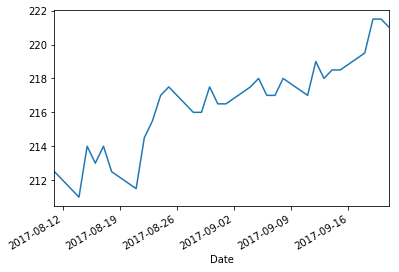

In [83]:
%matplotlib inline  
draw_table['Close'].plot(kind='line')

## 繪製K線圖 ##
[參考](https://www.quantopian.com/posts/plot-candlestick-charts-in-research)

In [103]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
def plot_candles(pricing, title=None, volume_bars=False, color_function=None, technicals=None):
    """ Plots a candlestick chart using quantopian pricing data.
    
    Author: Daniel Treiman
    
    Args:
      pricing: A pandas dataframe with columns ['open_price', 'close_price', 'high', 'low', 'volume']
      title: An optional title for the chart
      volume_bars: If True, plots volume bars
      color_function: A function which, given a row index and price series, returns a candle color.
      technicals: A list of additional data series to add to the chart.  Must be the same length as pricing.
    """
    def default_color(index, open_price, close_price, low, high):
        return 'r' if open_price[index] > close_price[index] else 'g'
    color_function = color_function or default_color
    technicals = technicals or []
    open_price = pricing['Open']
    close_price = pricing['Close']
    low = pricing['Low']
    high = pricing['High']
    oc_min = pd.concat([open_price, close_price], axis=1).min(axis=1)
    oc_max = pd.concat([open_price, close_price], axis=1).max(axis=1)
    
    if volume_bars:
        fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, gridspec_kw={'height_ratios': [3,1]})
    else:
        fig, ax1 = plt.subplots(1, 1)
    if title:
        ax1.set_title(title)
    x = np.arange(len(pricing))
    candle_colors = [color_function(i, open_price, close_price, low, high) for i in x]
    candles = ax1.bar(x, oc_max-oc_min, bottom=oc_min, color=candle_colors, linewidth=0)
    lines = ax1.vlines(x + 0.4, low, high, color=candle_colors, linewidth=1)
    ax1.xaxis.grid(False)
    ax1.xaxis.set_tick_params(which='major', length=3.0, direction='in', top='off')
    # Assume minute frequency if first two bars are in the same day.
    frequency = 'minute' if (pricing.index[1] - pricing.index[0]).days == 0 else 'day'
    time_format = '%d-%m-%Y'
    if frequency == 'minute':
        time_format = '%H:%M'
    # Set X axis tick labels.
    plt.xticks(x, [date.strftime(time_format) for date in pricing.index], rotation='vertical')
    for indicator in technicals:
        ax1.plot(x, indicator)
    
    if volume_bars:
        volume = pricing['volume']
        volume_scale = None
        scaled_volume = volume
        if volume.max() > 1000000:
            volume_scale = 'M'
            scaled_volume = volume / 1000000
        elif volume.max() > 1000:
            volume_scale = 'K'
            scaled_volume = volume / 1000
        ax2.bar(x, scaled_volume, color=candle_colors)
        volume_title = 'Volume'
        if volume_scale:
            volume_title = 'Volume (%s)' % volume_scale
        ax2.set_title(volume_title)
        ax2.xaxis.grid(False)

In [108]:
hist_table3 = hist_table2
hist_table3.index=hist_table3['Date']
hist_table3 = hist_table3.drop('Date', axis=1)
hist_table3

,Open,High,Low,Close,Volume
Date,,,,,
2017-09-21,221.0,223.0,220.0,221.0,18609000
2017-09-20,221.0,222.0,220.0,221.5,20278000
2017-09-19,221.5,221.5,220.0,221.5,23366000
2017-09-18,219.0,220.0,218.0,219.5,17614000
2017-09-15,218.5,219.0,217.0,218.5,44520000
2017-09-14,218.5,219.0,217.5,218.5,18297000
2017-09-13,217.5,219.0,217.5,218.0,17528000
2017-09-12,219.0,219.5,217.5,219.0,21540000
2017-09-11,219.0,219.5,216.5,217.0,18987000


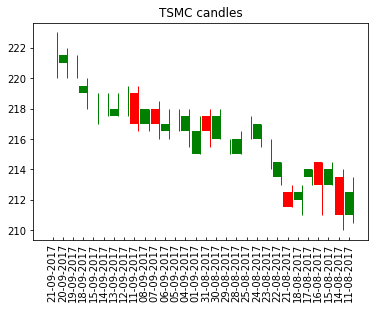

In [110]:
plot_candles(hist_table3, title='TSMC candles')